In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import QuantileRegressor
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')

In [ ]:
def uv_to_wsd(u_wind_speed, v_wind_speed):

    u_ws = u_wind_speed.to_numpy()
    v_ws = v_wind_speed.to_numpy()

    wind_speed = np.nansum([u_ws**2, v_ws**2], axis=0)**(1/2.)

    wind_direction = np.rad2deg(np.arctan2(v_ws, u_ws+1e-6))
    wind_direction[wind_direction < 0] += 360

    wind_direction = 270 - wind_direction
    wind_direction[wind_direction < 0] += 360

    return wind_speed, wind_direction

영광 20-22년도 발전량 학습

In [ ]:
# 20-22년도 데이터
df_feature = pd.read_pickle("/content/drive/MyDrive/BDA&동서발전 기상데이터/1-3. train_ldaps_yeonggwang.pkl")

# wind_speed 변수 추출
df_feature["wind_speed"], df_feature["wind_direction"] = uv_to_wsd(
    df_feature["wind_u_10m"], df_feature["wind_v_10m"])

# 변수 선택
df_x = df_feature.loc[:,['specific_humid', 'temp_air', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'turbine_id']]

# 월, 시간 변수 추출
df_x['month'] = df_x.index.month.astype('category')
df_x['hour'] = df_x.index.hour.astype('category')

In [ ]:
# 20-22년도 발전량
train_y = pd.read_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/1-1. train_y.csv")
train_y.end_datetime = pd.to_datetime(
    train_y.end_datetime
).dt.tz_convert("Asia/Seoul")

yg_y = train_y[train_y.plant_name == "영광풍력"]
true_y = yg_y.copy()[["end_datetime", "energy_kwh"]]

In [ ]:
# 수치형 변수 시간별 평균
wind_mean = df_x.groupby(df_x.index)['wind_speed'].mean().to_frame(name='wind_mean')
temp_mean = df_x.groupby(df_x.index)['temp_air'].mean().to_frame(name='temp_mean')
humi_mean = df_x.groupby(df_x.index)['specific_humid'].mean().to_frame(name='humi_mean')
uwin_mean = df_x.groupby(df_x.index)['wind_u_10m'].mean().to_frame(name='uwin_mean')
usto_mean = df_x.groupby(df_x.index)['storm_u_5m'].mean().to_frame(name='usto_mean')

In [ ]:
# 시간별 평균값으로 구성된 데이터프레임
ew = yg_y.merge(
    temp_mean.reset_index(),
    left_on="end_datetime",
    right_on="dt"
).merge(
    humi_mean.reset_index(),
    on="dt"
).merge(
    wind_mean.reset_index(),
    on="dt"
).merge(
    uwin_mean.reset_index(),
    on="dt"
).merge(
    usto_mean.reset_index(),
    on="dt"
)[["dt", "energy_kwh", "temp_mean", "humi_mean", "wind_mean", "uwin_mean", "usto_mean"]]
ew['month'] = ew['dt'].dt.month.astype('category')
ew['hour'] = ew['dt'].dt.hour.astype('category')

In [ ]:
# 데이터 준비
X = ew[["temp_mean", "humi_mean", "wind_mean", "uwin_mean", "usto_mean"]].values
y = ew['energy_kwh'].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)  # 독립변수 표준화

# 4차 다항 변환
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X_scaled)

# 발전량 학습
model = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
model.fit(X_poly, y)

QuantileRegressor(alpha=0)

In [ ]:
ls_pred = []

# 터빈별로 데이터를 나누어 20-22년도 발전량 예측
for turb in df_x['turbine_id'].unique():
    # 해당 터빈의 데이터 선택
    cur_x = df_x[df_x['turbine_id'] == turb][['temp_air', 'specific_humid', 'wind_speed', 'wind_u_10m', 'storm_u_5m']].copy().values

    X_scaled = scaler_X.transform(cur_x)
    X_new_poly = poly.transform(X_scaled)

    # 예측 수행
    cur_pred_y = model.predict(X_new_poly) / 35

    # 예측 결과를 데이터프레임으로 변환하고, 터빈 ID 추가
    cur_pred_df = pd.DataFrame({
        'predicted_energy_kwh': cur_pred_y,
        'turbine_id': turb
    })

    # 리스트에 추가
    ls_pred.append(cur_pred_df)

# 최종 데이터프레임으로 결합
df_pred_y = pd.concat(ls_pred, axis=0)
pred_y = df_pred_y.groupby(df_pred_y.index)['predicted_energy_kwh'].sum().to_frame()
pred_y = np.maximum(0, pred_y)

In [ ]:
# pred_y 인덱스 조정
df_x = df_x[df_x['turbine_id']=='WTG01']
df_x = df_x.reset_index()
pred_y['dt'] = df_x['dt']
pred_y = pred_y.set_index('dt')

# 실제발전량, 예측발전량 데이터프레임
result = true_y.merge(
    pred_y.reset_index(),
    left_on="end_datetime",
    right_on="dt"
)[["dt", "energy_kwh", "predicted_energy_kwh"]]

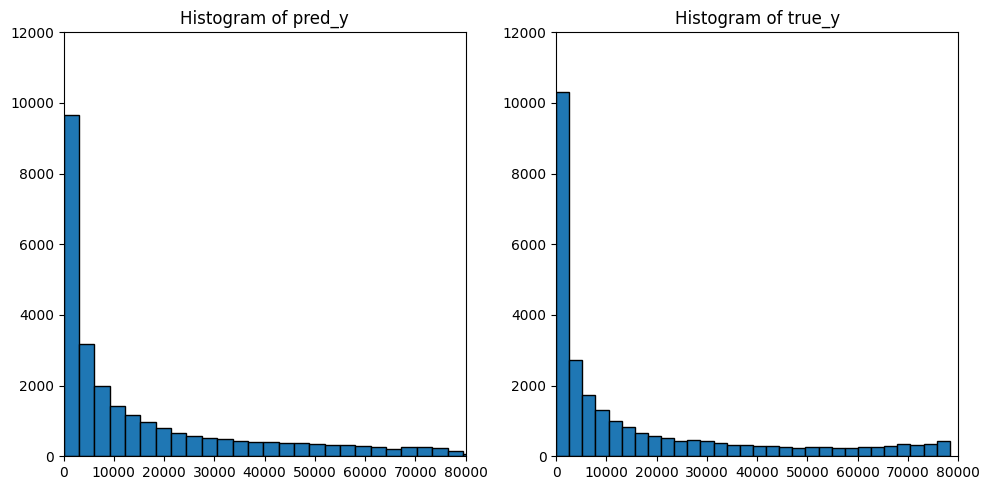

In [ ]:
# 발전량별 히스토그램
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(pred_y, bins=30, edgecolor='black')
plt.xlim(0, 80000)
plt.ylim(0, 12000)
plt.title('Histogram of pred_y')

plt.subplot(1, 2, 2)
plt.hist(true_y['energy_kwh'], bins=30, edgecolor='black')
plt.xlim(0, 80000)
plt.ylim(0, 12000)
plt.title('Histogram of true_y')

plt.tight_layout()
plt.show()

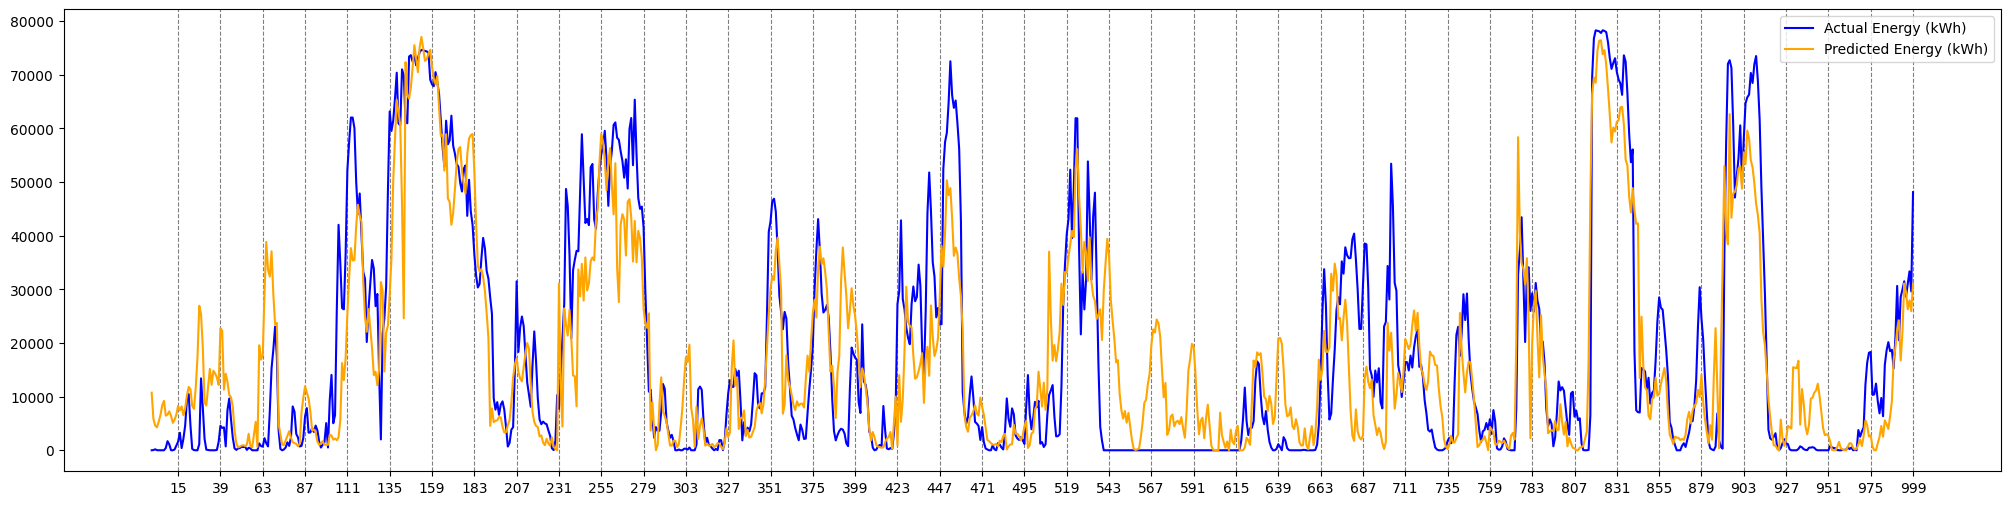

In [ ]:
#시간별 발전량 선그래프
plt.figure(figsize=(25, 6))

plt.plot(result.iloc[:1000,:].index, result.iloc[:1000,:].energy_kwh, label='Actual Energy (kWh)', color='blue')
plt.plot(result.iloc[:1000,:].index, result.iloc[:1000,:].predicted_energy_kwh, label='Predicted Energy (kWh)', color='orange')

# 15시부터 시작해서 24시간 간격으로 x축 격자 설정
start = 15
end = len(result.iloc[:1000, :].index)
xticks = list(range(start, end, 24))
plt.xticks(xticks)
plt.grid(which='major', axis='x', linestyle='--', color='grey')
plt.legend()
plt.show()


영광 23년도 예측

In [ ]:
df_feature = pd.read_pickle("/content/drive/MyDrive/BDA&동서발전 기상데이터/1-3. test_ldaps_gyeongju.pkl")

df_feature["wind_speed"], df_feature["wind_direction"] = uv_to_wsd(
    df_feature["wind_u_10m"], df_feature["wind_v_10m"])
df_feature["storm_speed"], df_feature["storm_direction"] = uv_to_wsd(
    df_feature["storm_u_5m"], df_feature["storm_v_5m"])

df_x = df_feature.loc[:,['specific_humid', 'temp_air', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'turbine_id']]

df_x['month'] = df_x.index.month.astype('category')
df_x['hour'] = df_x.index.hour.astype('category')

In [ ]:
ls_pred = []

# 터빈별로 데이터를 나누어 예측
for turb in df_x['turbine_id'].unique():
    # 해당 터빈의 데이터 선택
    cur_x = df_x[df_x['turbine_id'] == turb][['temp_air', 'specific_humid', 'wind_speed', 'wind_u_10m', 'storm_u_5m']].copy().values

    X_scaled = scaler_X.transform(cur_x)
    X_new_poly = poly.transform(X_scaled)

    # 예측 수행
    cur_pred_y = model.predict(X_new_poly) / 35

    # 예측 결과를 데이터프레임으로 변환하고, 터빈 ID 추가
    cur_pred_df = pd.DataFrame({
        'predicted_energy_kwh': cur_pred_y,
        'turbine_id': turb
    })

    # 리스트에 추가
    ls_pred.append(cur_pred_df)

# 최종 데이터프레임으로 결합
df_pred_y = pd.concat(ls_pred, axis=0)
pred_y = df_pred_y.groupby(df_pred_y.index)['predicted_energy_kwh'].sum().to_frame()
pred_y = np.maximum(0, pred_y)

In [ ]:
# pred_y 인덱스 조정
df_x = df_x[df_x['turbine_id']=='WTG01']
df_x = df_x.reset_index()  # 기존 인덱스를 칼럼으로 이동 ('dt'라는 이름으로 들어감)
pred_y['dt'] = df_x['dt']
pred_y = pred_y.set_index('dt')

In [ ]:
pred_y.to_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/영광23.csv")

In [ ]:
# 23년도 피처 & 예측발전량 합친 데이터프레임
df_feature_numeric = df_feature.select_dtypes(include='number')
df = df_feature_numeric.groupby(df_feature.index).mean()
train_y_dict = train_y.set_index('end_datetime')['energy_kwh'].to_dict()
df['energy_kwh'] = df.index.map(train_y_dict)

In [ ]:
df.to_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/영광종합.csv")

경주 20-22년도 발전량 학습

In [ ]:
# 20-22년도 데이터
df_feature = pd.read_pickle("/content/drive/MyDrive/BDA&동서발전 기상데이터/1-4. train_ldaps_gyeongju.pkl")

# wind_speed 변수 추출
df_feature["wind_speed"], df_feature["wind_direction"] = uv_to_wsd(
    df_feature["wind_u_10m"], df_feature["wind_v_10m"])
df_feature["storm_speed"], df_feature["storm_direction"] = uv_to_wsd(
    df_feature["storm_u_5m"], df_feature["storm_v_5m"])

# 변수 선택
df_x = df_feature.loc[:,['specific_humid', 'temp_air', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'turbine_id']]

# 월, 시간 변수 추출
df_x['month'] = df_x.index.month.astype('category')
df_x['hour'] = df_x.index.hour.astype('category')

In [ ]:
# 20-22년도 발전량
train_y = pd.read_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/1-1. train_y.csv")
train_y.end_datetime = pd.to_datetime(
    train_y.end_datetime
).dt.tz_convert("Asia/Seoul")

gj_y = train_y[train_y.plant_name == "경주풍력"]
true_y = gj_y.copy()[["end_datetime", "energy_kwh"]]

In [ ]:
# 수치형 변수 시간별 평균
wind_mean = df_x.groupby(df_x.index)['wind_speed'].mean().to_frame(name='wind_mean')
temp_mean = df_x.groupby(df_x.index)['temp_air'].mean().to_frame(name='temp_mean')
humi_mean = df_x.groupby(df_x.index)['specific_humid'].mean().to_frame(name='humi_mean')
uwin_mean = df_x.groupby(df_x.index)['wind_u_10m'].mean().to_frame(name='uwin_mean')
usto_mean = df_x.groupby(df_x.index)['storm_u_5m'].mean().to_frame(name='usto_mean')

In [ ]:
# 시간별 평균값으로 구성된 데이터프레임
ew = gj_y.merge(
    temp_mean.reset_index(),
    left_on="end_datetime",
    right_on="dt"
).merge(
    humi_mean.reset_index(),
    on="dt"
).merge(
    wind_mean.reset_index(),
    on="dt"
).merge(
    uwin_mean.reset_index(),
    on="dt"
).merge(
    usto_mean.reset_index(),
    on="dt"
)[["dt", "energy_kwh", "temp_mean", "humi_mean", "wind_mean", "uwin_mean", "usto_mean"]]
ew['month'] = ew['dt'].dt.month.astype('category')
ew['hour'] = ew['dt'].dt.hour.astype('category')

In [ ]:
# 데이터 준비
X = ew[["temp_mean", "humi_mean", "wind_mean", "uwin_mean", "usto_mean", "month", "hour"]].values
y = ew['energy_kwh'].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)  # 독립변수 표준화

# 4차 다항 변환
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X_scaled)

# 발전량 학습
model = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
model.fit(X_poly, y)

QuantileRegressor(alpha=0)

In [ ]:
ls_pred = []

# 터빈별로 데이터를 나누어 20-22년도 발전량 예측
for turb in df_x['turbine_id'].unique():
    # 해당 터빈의 데이터 선택
    cur_x = df_x[df_x['turbine_id'] == turb][['temp_air', 'specific_humid', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'month', 'hour']].copy().values

    X_scaled = scaler_X.transform(cur_x)
    X_new_poly = poly.transform(X_scaled)

    # 예측 수행
    cur_pred_y = model.predict(X_new_poly) / 9

    # 예측 결과를 데이터프레임으로 변환하고, 터빈 ID 추가
    cur_pred_df = pd.DataFrame({
        'predicted_energy_kwh': cur_pred_y,
        'turbine_id': turb
    })

    # 리스트에 추가
    ls_pred.append(cur_pred_df)

# 최종 데이터프레임으로 결합
df_pred_y = pd.concat(ls_pred, axis=0)
pred_y = df_pred_y.groupby(df_pred_y.index)['predicted_energy_kwh'].sum().to_frame()
pred_y = np.maximum(0, pred_y)

In [ ]:
# pred_y 인덱스 조정
df_x = df_x[df_x['turbine_id']=='WTG01']
df_x = df_x.reset_index()
pred_y['dt'] = df_x['dt']
pred_y = pred_y.set_index('dt')

# 실제발전량, 예측발전량 데이터프레임
result = true_y.merge(
    pred_y.reset_index(),
    left_on="end_datetime",
    right_on="dt"
)[["dt", "energy_kwh", "predicted_energy_kwh"]]

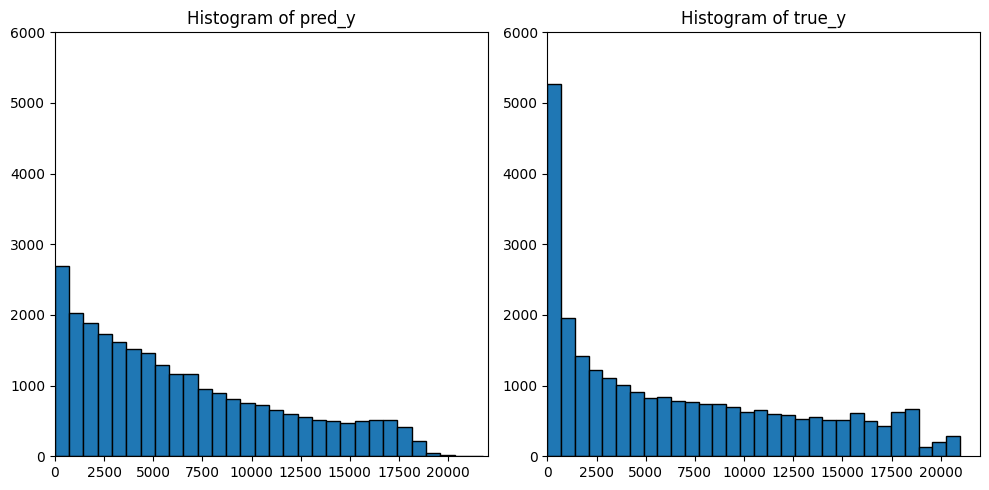

In [ ]:
# 발전량별 히스토그램
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(pred_y, bins=30, edgecolor='black')
plt.xlim(0, 22000)
plt.ylim(0, 6000)
plt.title('Histogram of pred_y')

plt.subplot(1, 2, 2)
plt.hist(true_y['energy_kwh'], bins=30, edgecolor='black')
plt.xlim(0, 22000)
plt.ylim(0,6000)
plt.title('Histogram of true_y')

plt.tight_layout()
plt.show()

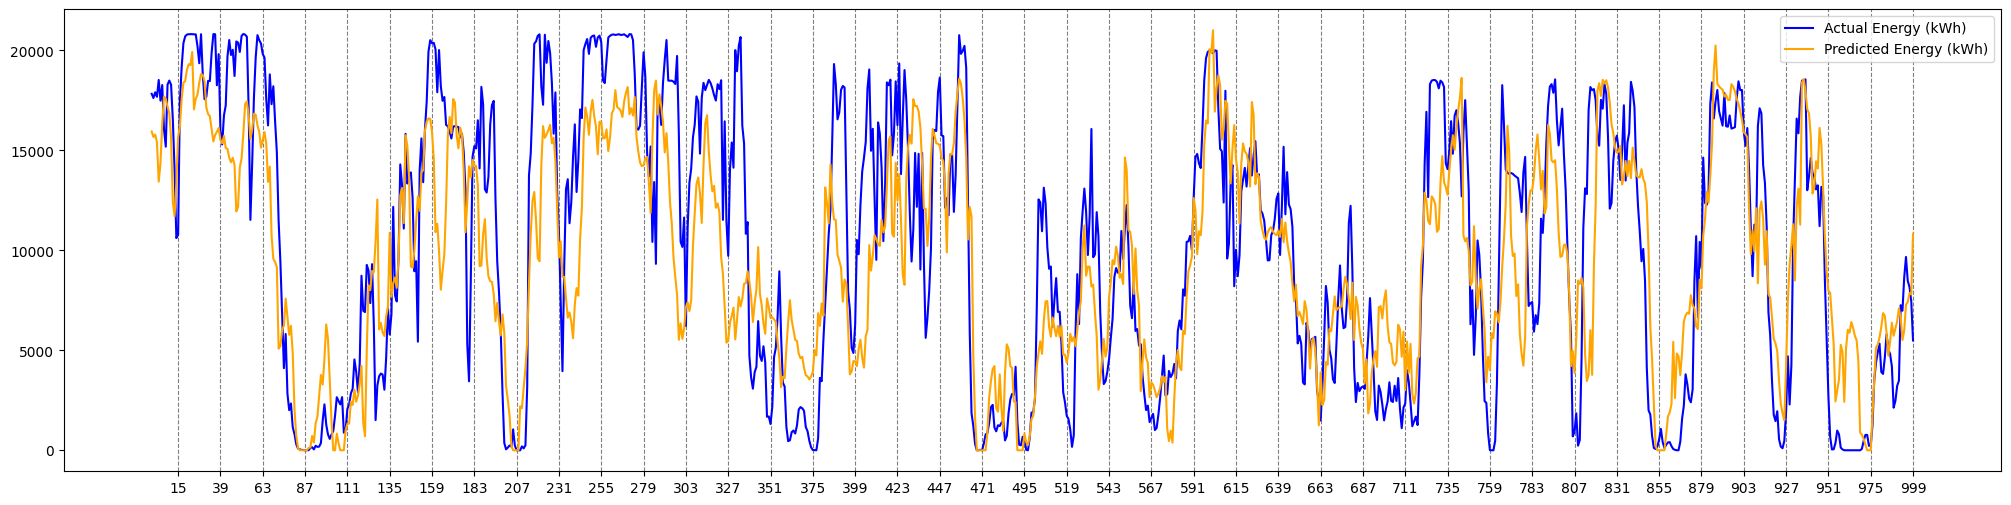

In [ ]:
#시간별 발전량 선그래프
plt.figure(figsize=(25, 6))

plt.plot(result.iloc[:1000,:].index, result.iloc[:1000,:].energy_kwh, label='Actual Energy (kWh)', color='blue')
plt.plot(result.iloc[:1000,:].index, result.iloc[:1000,:].predicted_energy_kwh, label='Predicted Energy (kWh)', color='orange')

# 15시부터 시작해서 24시간 간격으로 x축 격자 설정
start = 15
end = len(result.iloc[:1000, :].index)
xticks = list(range(start, end, 24))
plt.xticks(xticks)
plt.grid(which='major', axis='x', linestyle='--', color='grey')
plt.legend()
plt.show()


경주 23년도 예측

In [ ]:
df_feature = pd.read_pickle("/content/drive/MyDrive/BDA&동서발전 기상데이터/1-4. test_ldaps_gyeongju.pkl")

df_feature["wind_speed"], df_feature["wind_direction"] = uv_to_wsd(
    df_feature["wind_u_10m"], df_feature["wind_v_10m"])
df_feature["storm_speed"], df_feature["storm_direction"] = uv_to_wsd(
    df_feature["storm_u_5m"], df_feature["storm_v_5m"])

df_x = df_feature.loc[:,['specific_humid', 'temp_air', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'turbine_id']]

df_x['month'] = df_x.index.month.astype('category')
df_x['hour'] = df_x.index.hour.astype('category')

In [ ]:
ls_pred = []

# 터빈별로 데이터를 나누어 예측
for turb in df_x['turbine_id'].unique():
    # 해당 터빈의 데이터 선택
    cur_x = df_x[df_x['turbine_id'] == turb][['temp_air', 'specific_humid', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'month', 'hour']].copy().values

    X_scaled = scaler_X.transform(cur_x)
    X_new_poly = poly.transform(X_scaled)

    # 예측 수행
    cur_pred_y = model.predict(X_new_poly) / 9

    # 예측 결과를 데이터프레임으로 변환하고, 터빈 ID 추가
    cur_pred_df = pd.DataFrame({
        'predicted_energy_kwh': cur_pred_y,
        'turbine_id': turb
    })

    # 리스트에 추가
    ls_pred.append(cur_pred_df)

# 최종 데이터프레임으로 결합
df_pred_y = pd.concat(ls_pred, axis=0)
pred_y = df_pred_y.groupby(df_pred_y.index)['predicted_energy_kwh'].sum().to_frame()
pred_y = np.maximum(0, pred_y)

In [ ]:
# pred_y 인덱스 조정
df_x = df_x[df_x['turbine_id']=='WTG01']
df_x = df_x.reset_index()  # 기존 인덱스를 칼럼으로 이동 ('dt'라는 이름으로 들어감)
pred_y['dt'] = df_x['dt']
pred_y = pred_y.set_index('dt')

In [ ]:
pred_y.to_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/경주23.csv")

In [ ]:
# 23년도 피처 & 예측발전량 합친 데이터프레임
df_feature_numeric = df_feature.select_dtypes(include='number')
df = df_feature_numeric.groupby(df_feature.index).mean()
train_y_dict = true_y.set_index('end_datetime')['energy_kwh'].to_dict()
df['energy_kwh'] = df.index.map(train_y_dict)

In [ ]:
df

,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,wind_speed,wind_direction,storm_speed,storm_direction,energy_kwh
dt,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+09:00,303.944444,1.0,0.303777,5.798900,5.348697,99045.204861,89.492062,0.002686,269.864912,0.022297,-0.341105,3.483745,-3.513310,5.069140,316.997269,0.341838,356.231953,17827.148438
2020-01-02 01:00:00+09:00,303.944444,1.0,0.303777,5.515402,5.187633,99044.549479,89.176226,0.002686,269.839973,0.021554,-0.322241,3.523949,-3.239678,4.909303,314.675821,0.322965,356.152092,17616.210938
2020-01-02 02:00:00+09:00,303.944444,1.0,0.303777,5.727812,5.452497,99028.005208,90.353010,0.002686,269.821465,0.021668,-0.307603,3.648044,-3.044093,4.858896,311.916200,0.308370,355.948310,17904.296875
2020-01-02 03:00:00+09:00,303.944444,1.0,0.303777,5.751984,5.344749,98983.343750,91.400663,0.002686,269.747538,0.022008,-0.256693,3.566357,-2.674197,4.527577,308.777934,0.257644,355.052713,17676.757812
2020-01-02 04:00:00+09:00,303.944444,1.0,0.303777,5.352778,4.851507,98930.467882,89.163960,0.002686,269.704990,0.023732,-0.174836,3.045174,-2.193308,3.825456,308.336310,0.176475,352.095398,18519.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+09:00,303.944444,1.0,0.303777,9.547422,8.806269,99002.340278,74.180201,0.002686,271.695001,0.056003,-0.450630,6.249188,-2.881794,6.891809,295.021718,0.454105,352.898190,18488.281250
2022-12-31 20:00:00+09:00,303.944444,1.0,0.303777,9.305802,8.890261,98989.157118,76.329317,0.002686,271.688263,0.064570,-0.446123,6.384627,-3.658178,7.377446,300.120561,0.450788,351.738882,18394.531250
2022-12-31 21:00:00+09:00,303.944444,1.0,0.303777,9.148445,8.486347,98985.759549,79.236092,0.002686,271.246477,0.067479,-0.463339,5.918777,-3.392838,6.859299,300.463849,0.468237,351.697317,18443.359375


In [ ]:
df.to_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/경주종합2.csv")

15시 이전 데이터로 익일 발전량 예측

In [ ]:
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# ldaps
## 영광
train_yg = pd.read_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/영광종합.csv")
train_yg.set_index('dt', inplace=True)
train_yg.index = pd.to_datetime(train_yg.index).tz_convert('Asia/Seoul')


test_yg_y = pd.read_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/영광23.csv")
test_yg_y.set_index('dt', inplace=True)

test_yg = pd.read_pickle("/content/drive/MyDrive/BDA&동서발전 기상데이터/1-3. test_ldaps_yeonggwang.pkl")
test_yg = test_yg.select_dtypes(include='number').groupby(test_yg.index).mean()
test_yg = test_yg.merge(test_yg_y, how='outer', on=test_yg.index)
test_yg.set_index('key_0', inplace=True)
test_yg.index.name = 'dt'
test_yg.rename(columns={'predicted_energy_kwh': 'energy_kwh'}, inplace=True)

test_yg["wind_speed"], test_yg["wind_direction"] = uv_to_wsd(
    test_yg["wind_u_10m"], test_yg["wind_v_10m"]
)
test_yg["storm_speed"], test_yg["storm_direction"] = uv_to_wsd(
    test_yg["storm_u_5m"], test_yg["storm_v_5m"]
)


## 경주
train_gj = pd.read_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/경주종합.csv")
train_gj.set_index('dt', inplace=True)
train_gj.index = pd.to_datetime(train_gj.index).tz_convert('Asia/Seoul')

test_gj_y = pd.read_csv("/content/drive/MyDrive/BDA&동서발전 기상데이터/경주23.csv")
test_gj_y.set_index('dt', inplace=True)

test_gj = pd.read_pickle("/content/drive/MyDrive/BDA&동서발전 기상데이터/1-4. test_ldaps_gyeongju.pkl")
test_gj = test_gj.select_dtypes(include='number').groupby(test_gj.index).mean()
test_gj = test_gj.merge(test_gj_y, how='outer', on=test_gj.index)
test_gj.set_index('key_0', inplace=True)
test_gj.index.name = 'dt'
test_gj.rename(columns={'predicted_energy_kwh': 'energy_kwh'}, inplace=True)

test_gj["wind_speed"], test_gj["wind_direction"] = uv_to_wsd(
    test_gj["wind_u_10m"], test_gj["wind_v_10m"]
)
test_gj["storm_speed"], test_gj["storm_direction"] = uv_to_wsd(
    test_gj["storm_u_5m"], test_gj["storm_v_5m"]
)

# 1 data preprocessing

## 1-2 test data에 lookback_time까지
- 2022-12-31 데이터가 포함되도록

### (1) test 데이터에 2022년 데이터 일부 붙이기
- lookback_days에 따라 2022년 12월 혹은 11월 데이터까지 사용해야할 수도 있음

In [ ]:
# 영광
test_yg_added = pd.concat([train_yg[train_yg.index >= '2022-11-01 00:00:00+09:00'], test_yg])
test_yg_added.index = pd.to_datetime(test_yg_added.index)
# 경주
test_gj_added = pd.concat([train_gj[train_gj.index >= '2022-11-01 00:00:00+09:00'], test_gj])
test_gj_added.index = pd.to_datetime(test_gj_added.index)

### (2) lookback_days 정의 후 lookback 계산

In [ ]:
# lookback_days : 며칠 전까지를 x시퀀스로 만들건지
lookback_days = 5

# 시간화
lookback = 24 * lookback_days

In [ ]:
# 영광
yg_offset = test_yg_added[test_yg_added.index == '2022-12-31 00:00:00+09:00'].index[0] - pd.Timedelta(hours=lookback)
test_yg_final = test_yg_added[test_yg_added.index >= yg_offset]
test_yg_final['month'] = test_yg_final.index.month.astype('category')
test_yg_final['hour'] = test_yg_final.index.hour.astype('category')

# 경주
gj_offset = test_gj_added[test_gj_added.index == '2022-12-31 00:00:00+09:00'].index[0] - pd.Timedelta(hours=lookback)
test_gj_final = test_gj_added[test_gj_added.index >= gj_offset]
test_gj_final['month'] = test_gj_final.index.month.astype('category')
test_gj_final['hour'] = test_gj_final.index.hour.astype('category')

<ipython-input-185-13b52f94d68d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_yg_final['month'] = test_yg_final.index.month.astype('category')
<ipython-input-185-13b52f94d68d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_yg_final['hour'] = test_yg_final.index.hour.astype('category')
<ipython-input-185-13b52f94d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
# 전날 15시까지의 데이터를 사용하여 다음날 23시까지 예측
def create_features(feature, target, lookback, forecast_horizon=32):
    X, y = [], []

    for i in range(lookback, len(feature) - forecast_horizon):
      current_time = feature.index[i]  # 현재 인덱스의 시간

      if current_time.hour == 15:  # 15시까지의 데이터를 사용하여 예측
          x_1 = feature.iloc[(i - lookback) : (i + 1)][['energy_kwh', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'temp_air', 'specific_humid']].values.flatten().reshape(1, -1)
          x_2 = np.array([feature[['month', 'hour']].values[i]])
          #x_2 = np.array([feature[['month', 'day', 'weekday', 'hour']].values[i]])
          x_to = np.hstack([x_1, x_2])
          X.append(x_to.reshape(-1))  # 과거 (lookback)시간의 피처 데이터

          y_1 = feature.iloc[(i + 1) : (i + 1 + forecast_horizon)]['energy_kwh'].values
          y.append(y_1.flatten())  # 다음 32시간 동안의 예측 값

    return np.array(X), np.array(y)

**경주 예측**

In [ ]:
gj_list = []
# 영광

# 피처와 타겟 정의
train_features = train_gj[['energy_kwh', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'temp_air', 'specific_humid']]
train_target = train_gj[['energy_kwh']]

test_features = test_gj_final[['energy_kwh', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'temp_air', 'specific_humid']]
test_target = test_gj_final[['energy_kwh']]

# 데이터 스케일링 (기온, 습도, 기압, 풍속을 포함한 전체 스케일링)
scaler_features = MinMaxScaler()  # 기온, 습도, 기압 피처에 대해 사용
scaler_target = MinMaxScaler()

scaled_x_train = pd.DataFrame(scaler_features.fit_transform(train_features), columns = ['energy_kwh', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'temp_air', 'specific_humid'])  # train_features에 다차원 배열 입력
scaled_x_test = pd.DataFrame(scaler_features.transform(test_features) , columns = ['energy_kwh', 'wind_speed', 'wind_u_10m', 'storm_u_5m', 'temp_air', 'specific_humid'])       # test_features도 동일한 방식으로 변환

scaled_x_train.set_index(train_gj.index, inplace=True)
scaled_x_test.set_index(test_gj_final.index, inplace=True)

# 풍속 데이터에 대한 스케일링
scaled_y_train = pd.DataFrame(scaler_target.fit_transform(train_target), columns = ['energy_kwh'])  # 풍속 스케일링
scaled_y_test = pd.DataFrame(scaler_target.transform(test_target), columns = ['energy_kwh'])       # 테스트 데이터도 변환

scaled_y_train.set_index(train_gj.index, inplace=True)
scaled_y_test.set_index(test_gj_final.index, inplace=True)

# month, day, weekday
scaled_x_train['month'] = scaled_x_train.index.month
scaled_x_train['hour'] = scaled_x_train.index.hour

scaled_x_test['month'] = scaled_x_test.index.month
scaled_x_test['hour'] = scaled_x_test.index.hour

scaled_y_train['month'] = scaled_y_train.index.month
scaled_y_train['hour'] = scaled_y_train.index.hour

scaled_y_test['month'] = scaled_y_test.index.month
scaled_y_test['hour'] = scaled_y_test.index.hour


# 훈련 데이터 및 테스트 데이터 생성
X_train, y_train = create_features(feature = scaled_x_train, target = scaled_y_train, lookback = lookback)
X_test, y_test = create_features(feature = scaled_x_test, target = scaled_y_test, lookback = lookback)

# XGBoost 모델 훈련
xgb_model = RandomForestRegressor(n_estimators=500, random_state=0, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
pred_xgb = xgb_model.predict(X_test)

y_test = scaler_target.inverse_transform(y_test)
pred_xgb = scaler_target.inverse_transform(pred_xgb)

# RMSE 계산
xgb_rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
print(f"XGBoost RMSE: {xgb_rmse}")

# R² 계산
xgb_r2 = r2_score(y_test, pred_xgb)
print(f"XGBoost R²: {xgb_r2}")

# 데이터프레임화
target_df = pd.DataFrame(pred_xgb)

# 다음날 24시간 데이터만 뽑기
target_filtered = target_df.iloc[:, -24:]
target_reshaped = target_filtered.values.flatten()
target_transposed_pred = target_reshaped.transpose()

# 다시 한번 데이터 프레임화
gj_final = pd.DataFrame(target_transposed_pred, columns=['pred_energy'])

# 시간 컬럼 붙이기
gj_final['dt'] = test_gj_final.index[lookback+24:]

XGBoost RMSE: 3596.6520999893282
XGBoost R²: 0.433851833087328


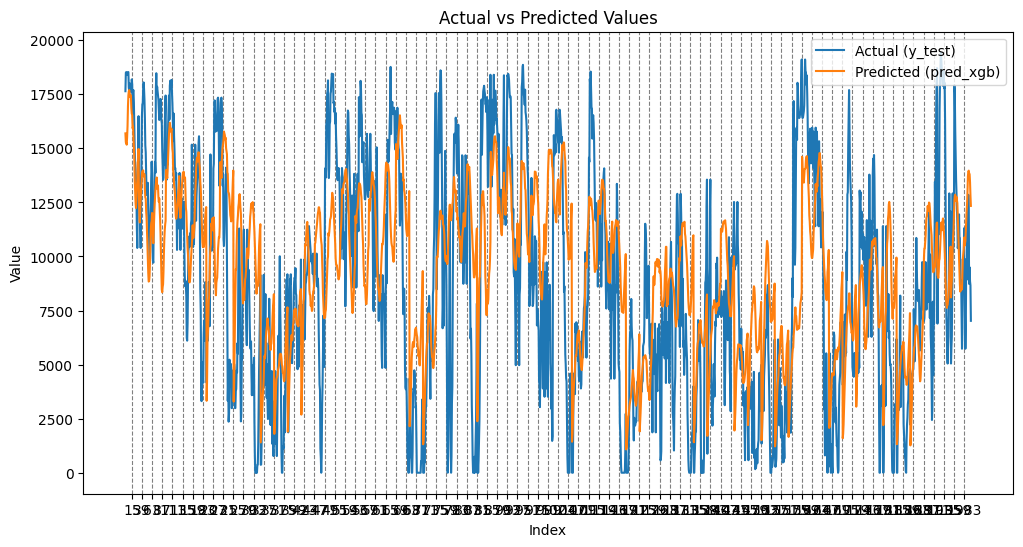

In [ ]:
# y_test와 pred_xgb 선 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(y_test.reshape(-1)[:2000], label='Actual (y_test)')
plt.plot(pred_xgb.reshape(-1)[:2000], label='Predicted (pred_xgb)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()

# 15시부터 시작해서 24시간 간격으로 x축 격자 설정
start = 15
end = len(y_test.reshape(-1)[:2000])
xticks = list(range(start, end, 24))
plt.xticks(xticks)
plt.grid(which='major', axis='x', linestyle='--', color='grey')

plt.show()

In [ ]:
true_y = y_test.reshape(-1)
true_y = pd.DataFrame(true_y, columns=['energy_kwh'])
pred_y = pred_xgb.reshape(-1)
pred_y = pd.DataFrame(pred_y, columns=['predicted_energy_kwh'])
result = pd.merge(true_y, pred_y, left_index=True, right_index=True, suffixes=('_true', '_pred'))
result["capacity"] = 20700

# 지표 계산하기
result["normalized_abs_error"] = abs(result.predicted_energy_kwh-result.energy_kwh)/result.capacity*100
result['incentive'] = 0.
result.loc[(result.normalized_abs_error > 6) & (result.normalized_abs_error <= 8), 'incentive'] = 3.
result.loc[(result.normalized_abs_error <= 6), 'incentive'] = 4.
result.loc[result.energy_kwh < result.capacity*0.1, 'incentive'] = 0.

nmae = round(result.normalized_abs_error.mean(), 2)
total_incentive = np.floor((result.incentive * result.energy_kwh).sum())
available_max_incentive = np.floor((4*result.energy_kwh[result.energy_kwh>=result.capacity*0.1])).sum()

print("NMAE =", nmae, "%")
print("예측정산금획득율 =", round(total_incentive/available_max_incentive*100, 2), "%")
print("예측제도정산금 =", int(total_incentive), "원")

NMAE = 13.3 %
예측정산금획득율 = 33.61 %
예측제도정산금 = 89050117 원


In [ ]:
pred_y

,predicted_energy_kwh
0,15693.779297
1,15276.832031
2,15247.146484
3,15171.587891
4,15517.058594
...,...
11675,8496.070312
11676,8518.062500
11677,8824.980469
11678,8970.242187
